In [1]:
import numpy as np
import torch
import torchmetrics
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
dataset = load_sample_images()
len(dataset.images)

2

In [4]:
images = dataset.images
images[0].shape

(427, 640, 3)

In [5]:
sample_images = np.stack(images)
sample_images = torch.tensor(sample_images, dtype = torch.float32) / 255

In [6]:
sample_images.shape

torch.Size([2, 427, 640, 3])

In [7]:
sample_images_permuted = sample_images.permute(0, 3, 1,2)
sample_images_permuted.shape

torch.Size([2, 3, 427, 640])

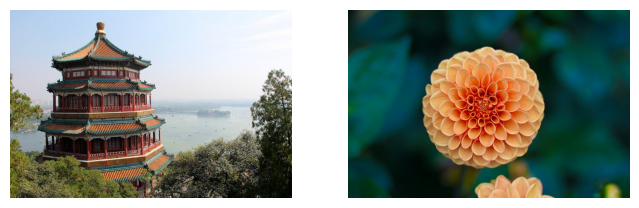

In [8]:
def plot_image(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")

plt.figure(figsize=(8,4))
for index, image in enumerate(sample_images_permuted):
    plt.subplot(1,2,index + 1)
    plot_image(image)

In [9]:
import torchvision.transforms.v2 as T
cropped_images = T.CenterCrop((70,120))(sample_images_permuted)
cropped_images.shape

torch.Size([2, 3, 70, 120])

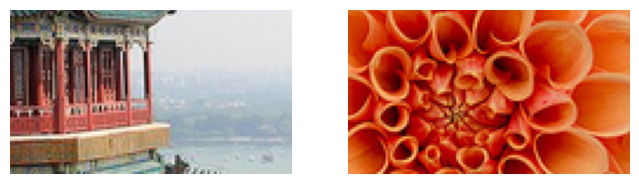

In [10]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_image(cropped_images[0])
plt.subplot(122)
plot_image(cropped_images[1])

In [11]:
torch.manual_seed(42)

conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7)
fmaps = conv_layer(cropped_images)

In [12]:
fmaps[0].shape

torch.Size([32, 64, 114])

(np.float64(-0.5), np.float64(113.5), np.float64(63.5), np.float64(-0.5))

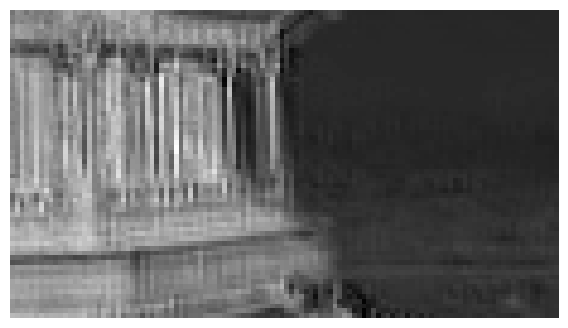

In [13]:
plt.figure(figsize=(8,4))
plt.imshow(fmaps[0][0].detach(), cmap="gray")
plt.axis("off")

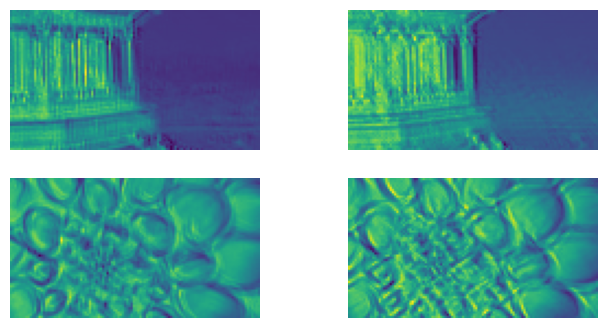

In [14]:
plt.figure(figsize=(8,4))
for image_idx in (0,1):
    for fmap_idx in (0,1):
        plt.subplot(2,2,2 * image_idx + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, fmap_idx].detach())
        plt.axis("off")

In [15]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7,
                       padding="same")
fmaps = conv_layer(cropped_images)
fmaps.shape

torch.Size([2, 32, 70, 120])

In [16]:
conv_layer.weight.shape

torch.Size([32, 3, 7, 7])

In [17]:
conv_layer.bias.shape

torch.Size([32])

In [18]:
import torch.nn.functional as F

torch.manual_seed(42)
filters = torch.rand([2,3,7,7])
biases = torch.zeros([2])
fmaps = F.conv2d(cropped_images, filters, biases, stride = 1, padding = "same")
fmaps.shape

torch.Size([2, 2, 70, 120])

(np.float64(-0.5), np.float64(119.5), np.float64(69.5), np.float64(-0.5))

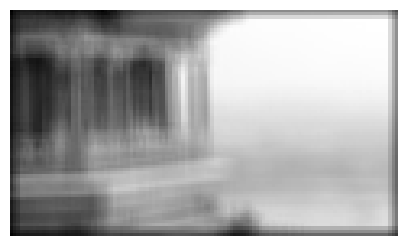

In [19]:
plt.figure(figsize=(5,4))
plt.imshow(fmaps[0][0].detach(), cmap="grey")
plt.axis("off")

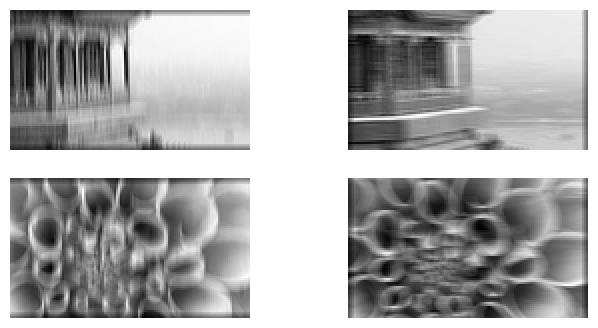

In [20]:
plt.figure(figsize=(8,4))
filters = torch.zeros([2,3,7,7])
filters[0,:, :, 3] = 1
filters[1,:,3, :] = 1
fmaps = F.conv2d(cropped_images, filters, biases, stride=1, padding="same")

for image_idx in (0,1):
    for fmap_idx in {0,1}:
        plt.subplot(2,2,2 * image_idx + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, fmap_idx].detach(), cmap="grey")
        plt.axis("off")

#### Implementing Pooling layers in Pytorch

In [21]:
max_pool = nn.MaxPool2d(kernel_size=2)
output_max = max_pool(cropped_images)

In [22]:
output_max[0].shape

torch.Size([3, 35, 60])

In [23]:
avg_pool = nn.AvgPool2d(kernel_size=2)
output_avg = avg_pool(cropped_images)

In [24]:
cropped_images[0].shape

torch.Size([3, 70, 120])

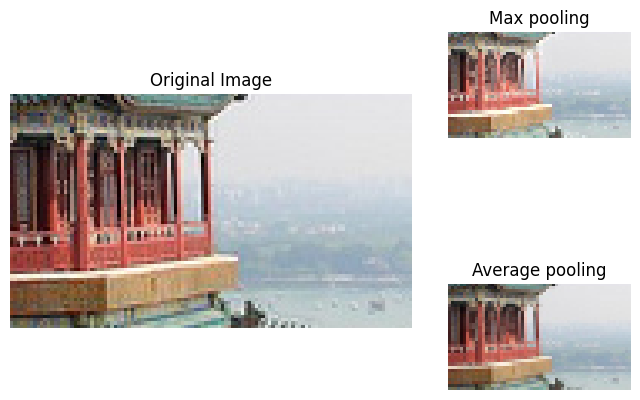

In [25]:
fig = plt.figure(figsize=(8,6))

ax1 = plt.subplot2grid((2,3), (0,0), rowspan=2, colspan=2)
ax1.imshow(cropped_images[0].permute(1,2,0))
ax1.axis("off")
ax1.set_title("Original Image")

ax2 = plt.subplot2grid((2,3), (0,2), rowspan=1, colspan=1)
ax2.imshow(output_max[0].permute(1,2,0))
ax2.axis("off")
ax2.set_title("Max pooling")

ax3 = plt.subplot2grid((2,3), (1,2))
ax3.imshow(output_avg[0].permute(1,2,0))
ax3.axis("off")
ax3.set_title("Average pooling")

plt.show()

##### Depth-Wise Pooling

In [26]:
import torch.nn.functional as F

In [27]:
class DepthPool(nn.Module):
    def __init__(self, kernel_size, padding = 0, stride = None):
        super().__init__()
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride

    def forward(self, inputs):
        batch, channels, height, width = inputs.shape
        Z = inputs.view(batch, channels, height * width)
        Z = Z.permute(0, 2, 1)
        Z = F.max_pool1d(Z, kernel_size=self.kernel_size, stride=self.stride,
                         padding = self.padding)
        Z = Z.permute(0,1,2)
        return Z.view(batch, -1, height, width)
    